In [1]:
# Import Libraries
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import copy
import pandas as pd
from pandas import read_csv
import seaborn as sns
import cv2
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sqlalchemy import create_engine
from sklearn.metrics import confusion_matrix, classification_report
import string
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.decomposition import PCA,TruncatedSVD, IncrementalPCA
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
file = './data/csi_data16QAM.csv'#'AI/Advertising Dataset.csv'#

In [3]:
print(read_csv(file))

                9.858       9.858.1       9.858.2       9.858.3
0        7.122500e+00  7.122500e+00  7.122500e+00  7.122500e+00
1        9.467600e+00  9.467600e+00  9.467600e+00  9.467600e+00
2        7.026500e+00  7.026500e+00  7.026500e+00  7.026500e+00
3        9.143400e+00  9.143400e+00  9.143400e+00  9.143400e+00
4        6.932500e+00  6.932500e+00  6.932500e+00  6.932500e+00
...               ...           ...           ...           ...
6475665  2.740100e-02  2.740100e-02  2.740100e-02  2.740100e-02
6475666  2.418200e+06  2.418200e+06  2.418200e+06  2.418200e+06
6475667  2.000000e+01  2.000000e+01  2.000000e+01  2.000000e+01
6475668  9.472700e-01  9.472700e-01  9.472700e-01  9.472700e-01
6475669  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00

[6475670 rows x 4 columns]


In [3]:
df = read_csv(file,header=None)

In [4]:
df

,0,1,2,3
0,9.858000e+00,9.858000e+00,9.858000e+00,9.858000e+00
1,7.122500e+00,7.122500e+00,7.122500e+00,7.122500e+00
2,9.467600e+00,9.467600e+00,9.467600e+00,9.467600e+00
3,7.026500e+00,7.026500e+00,7.026500e+00,7.026500e+00
4,9.143400e+00,9.143400e+00,9.143400e+00,9.143400e+00
...,...,...,...,...
6475666,2.740100e-02,2.740100e-02,2.740100e-02,2.740100e-02
6475667,2.418200e+06,2.418200e+06,2.418200e+06,2.418200e+06
6475668,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01
6475669,9.472700e-01,9.472700e-01,9.472700e-01,9.472700e-01


In [5]:
data = np.array(df)

In [6]:
data[16728:16733]   # BER, max throughput, SNR, Code_rate, Modulation

array([[ 4.6650e-01,  4.6650e-01,  4.6650e-01,  4.6650e-01],
       [ 2.9728e+05,  2.9728e+05,  2.9728e+05,  2.9728e+05],
       [-1.0000e+01, -1.0000e+01, -1.0000e+01, -1.0000e+01],
       [ 1.1719e-01,  1.1719e-01,  1.1719e-01,  1.1719e-01],
       [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00]])

In [7]:
data_ch = data[:,0]
print(data_ch[16728:16733])

[ 4.6650e-01  2.9728e+05 -1.0000e+01  1.1719e-01  1.0000e+00]


In [8]:
data_ch = np.reshape(data_ch,(-1,16733))
print(data_ch)

[[  9.858     7.1225    9.4676  ... -10.        0.11719   1.     ]
 [  1.6488    0.95614   1.6194  ...  10.        0.11719   1.     ]
 [  8.8256    8.8775    9.0031  ... -10.        0.23438   1.     ]
 ...
 [  1.6605    1.0832    1.6503  ...  18.        0.94727   1.     ]
 [  1.6574    1.0772    1.6479  ...  19.        0.94727   1.     ]
 [  1.4949    1.0295    1.5102  ...  20.        0.94727   1.     ]]


In [19]:
data_ch[:,16730]            # SNR

array([-10.,  10., -10.,  10., -10.,  10., -10.,  10., -10.,  10., -10.,
        10., -10.,  10., -10.,  10., -10.,  10., -20., -19., -18., -17.,
       -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,
        -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,
         6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,
        17.,  18.,  19.,  20., -20., -19., -18., -17., -16., -15., -14.,
       -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,
        -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
         9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,
        20., -20., -19., -18., -17., -16., -15., -14., -13., -12., -11.,
       -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20., -20., -19.,
       -18., -17., -16., -15., -14., -13., -12., -1

In [20]:
data_ch = data_ch[18:]

In [25]:
len(data_ch)

369

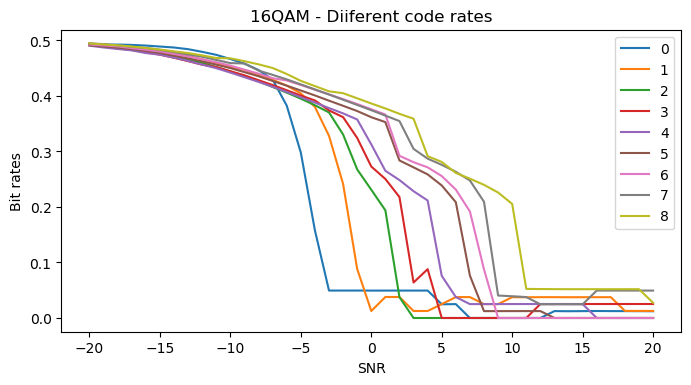

In [28]:
fig,ax = plt.subplots(figsize=(8,4),dpi=100)
for i in range(9):
    
    ax.plot(data_ch[i*41:(i+1)*41,16730],data_ch[i*41:(i+1)*41,16728],label=str(i))
    ax.legend(loc=1)
    ax.set_title('16QAM - Diiferent code rates')
    ax.set_xlabel('SNR')
    ax.set_ylabel('Bit rates')
    
plt.show()

In [45]:
scaler = MinMaxScaler()
data_feat = np.float64(data_ch)
data_rescaled = np.float64(scaler.fit_transform(data_feat))
pca = IncrementalPCA(n_components=10,batch_size=100)

In [46]:
#test_rescaled = scaler.fit_transform(X_test)

In [48]:
data_feat[:,16729]

array([ 297280.,  297280.,  594240.,  594240.,  962880.,  962880.,
       1208600., 1208600., 1475800., 1475800., 1803800., 1803800.,
       1926700., 1926700., 2171800., 2171800., 2418200., 2418200.,
        297280.,  297280.,  297280.,  297280.,  297280.,  297280.,
        297280.,  297280.,  297280.,  297280.,  297280.,  297280.,
        297280.,  297280.,  297280.,  297280.,  297280.,  297280.,
        297280.,  297280.,  297280.,  297280.,  297280.,  297280.,
        297280.,  297280.,  297280.,  297280.,  297280.,  297280.,
        297280.,  297280.,  297280.,  297280.,  297280.,  297280.,
        297280.,  297280.,  297280.,  297280.,  297280.,  594240.,
        594240.,  594240.,  594240.,  594240.,  594240.,  594240.,
        594240.,  594240.,  594240.,  594240.,  594240.,  594240.,
        594240.,  594240.,  594240.,  594240.,  594240.,  594240.,
        594240.,  594240.,  594240.,  594240.,  594240.,  594240.,
        594240.,  594240.,  594240.,  594240.,  594240.,  5942

In [ ]:
svd = TruncatedSVD(n_components=50, n_iter=20, random_state=42)

In [ ]:
svd.fit(data_rescaled)

In [ ]:
print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())
print(svd.singular_values_)

In [57]:
pca = IncrementalPCA(n_components=15,batch_size=100)

In [58]:
pca.fit(data_rescaled)

IncrementalPCA(batch_size=100, copy=True, n_components=15, whiten=False)

In [59]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())
print(pca.singular_values_)

[9.92503810e-01 1.17609761e-03 9.82489831e-04 8.02301993e-04
 6.73875204e-04 5.99077033e-04 5.82055212e-04 4.72772635e-04
 4.39374168e-04 2.84146128e-04 2.28663225e-04 1.94300673e-04
 1.37792884e-04 1.21927656e-04 9.42200764e-05]
0.9992929038638346
[479.28670696  16.49874749  15.07972164  13.62693638  12.4887517
  11.77526333  11.60677015  10.4605726   10.08431847   8.10961363
   7.27490716   6.70604471   5.64732377   5.31227325   4.66982944]


In [112]:
data_trans = pca.transform(data_rescaled)

In [115]:
test_trans = pca.transform(test_rescaled)

In [116]:
data_trans.shape

(10000, 100)

In [64]:
X_train = data_rescaled[:,:16731]
print(X_train.shape)

(387, 16731)


In [87]:
y_train = data_rescaled[:,16731:]
print(y_train.shape)

(387, 2)


In [88]:
pca = IncrementalPCA(n_components=1)

In [89]:
pca.fit(y_train)

IncrementalPCA(batch_size=None, copy=True, n_components=1, whiten=False)

In [90]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())
print(pca.singular_values_)

[1.]
1.0000000000000002
[6.28359993]


In [91]:
y_train = pca.transform(y_train)
print(y_train)

[[-0.53463923]
 [-0.53463923]
 [-0.39346007]
 [-0.39346007]
 [-0.21699515]
 [-0.21699515]
 [-0.09934384]
 [-0.09934384]
 [ 0.03006538]
 [ 0.03006538]
 [ 0.17124454]
 [ 0.17124454]
 [ 0.23005815]
 [ 0.23005815]
 [ 0.34770946]
 [ 0.34770946]
 [ 0.46536077]
 [ 0.46536077]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.53463923]
 [-0.39346007]
 [-0.39346007]
 [-0.39346007]
 [-0.39346007]
 [-0.39346007]
 [-0.39346007]
 [-0.39346007]
 [-0.39346

In [92]:
y_train = np.round(10*y_train)
print(y_train)

[[-5.]
 [-5.]
 [-4.]
 [-4.]
 [-2.]
 [-2.]
 [-1.]
 [-1.]
 [ 0.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 3.]
 [ 3.]
 [ 5.]
 [ 5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-5.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-4.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-2.]
 [-1.]
 [-1.]

In [93]:
y_train = y_train+5
print(y_train)

[[ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 3.]
 [ 3.]
 [ 4.]
 [ 4.]
 [ 5.]
 [ 5.]
 [ 7.]
 [ 7.]
 [ 7.]
 [ 7.]
 [ 8.]
 [ 8.]
 [10.]
 [10.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 4.]
 [ 4.]

In [102]:
y_train.shape

(387, 1)

In [94]:
lda = LinearDiscriminantAnalysis(n_components=11)
lda.fit(X_train, y_train)

/home/shubham/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/shubham/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(16731, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
/home/shubham/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


LinearDiscriminantAnalysis(n_components=11, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

(387, 7)


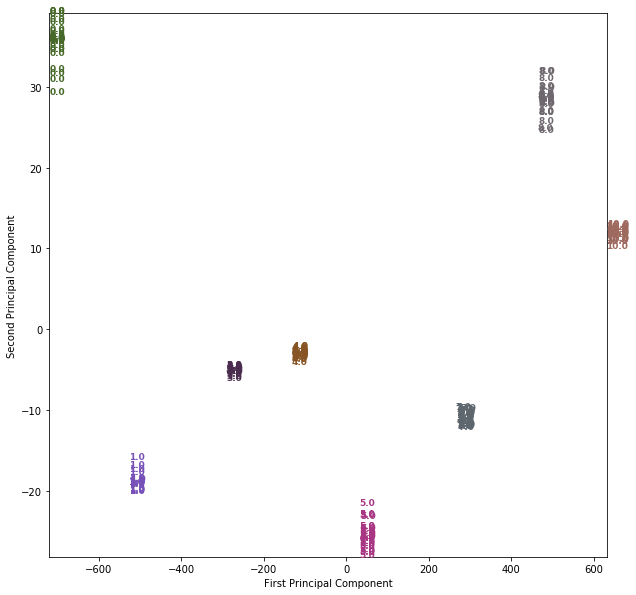

In [113]:
trainX_lda = lda.transform(X_train)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#3E655E","#5E666E","#6E676E","#7E685E","#9E695E"]
plt.figure(figsize=(10, 10))
plt.xlim(trainX_lda[:, 0].min(), trainX_lda[:, 0].max())
plt.ylim(trainX_lda[:, 1].min(), trainX_lda[:, 1].max())
print(trainX_lda.shape)
for i in range(len(trainX_lda)):
    # actually plot the digits as text instead of using scatter
    plt.text(trainX_lda[i, 0], trainX_lda[i, 1], str(y_train[i,0]),
             color=colors[int(y_train[i,0])], fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show(block=True)

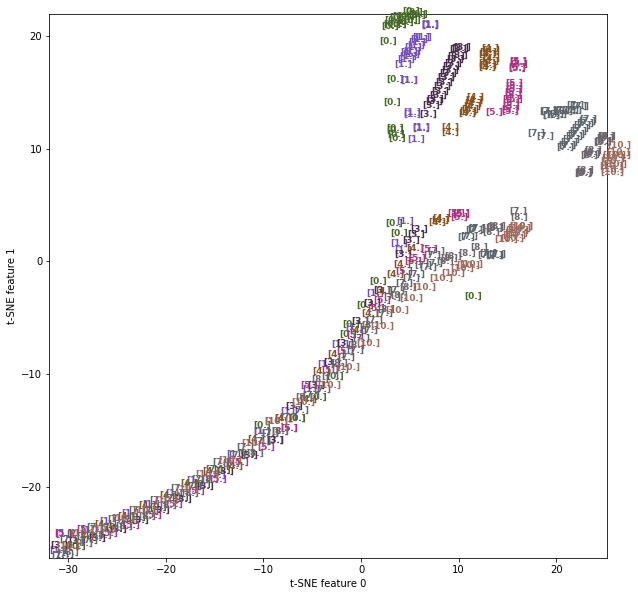

In [114]:
tsne = TSNE(random_state=21)
# use fit_transform instead of fit, as TSNE has no transform method
trainX_tsne = tsne.fit_transform(X_train)
plt.figure(figsize=(10, 10))
plt.xlim(trainX_tsne[:, 0].min(), trainX_tsne[:, 0].max())
plt.ylim(trainX_tsne[:, 1].min(), trainX_tsne[:, 1].max())
for i in range(len(trainX_tsne)):
    # actually plot the digits as text instead of using scatter
    plt.text(trainX_tsne[i, 0], trainX_tsne[i, 1], str(y_train[i]),
            color=colors[int(y_train[i])], fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")
plt.show(block=True)

In [115]:
trainX_tsne.shape

(387, 2)

In [98]:
testX_tsne.shape

(1000, 2)

In [39]:
X_train = np.concatenate((X_train,trainX_tsne),axis=1)

In [43]:
X_test = np.concatenate((X_test,testX_tsne),axis=1)

In [ ]:
l = np.unique(data_new[:,7])
print(l.shape)

In [ ]:
corr_data = pd.DataFrame({data_fn})

In [ ]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
print(data_fn[0])
print(data_new[0][335:365])

In [ ]:
data_new.shape

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_new[:,1:], data_new[:,0], test_size=0.1, random_state=42)

In [10]:
X_train.shape

(9000, 362)

In [11]:
y_test.shape

(1000,)

In [49]:
xgb_model = xgb.XGBClassifier()#(xgb_model='best_grid.pkl')#xgb.train(loaded_params,xgb_model=)#

parameters = {'nthread':[3], #when use hyperthread, xgboost may become slower
              'objective':['multi:softmax'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [15],
              'min_child_weight': [15],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [1.0],
              'n_estimators': [10], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}


clf = RandomizedSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=10, 
                   scoring='accuracy',
                   verbose=2, refit=True)
X_tr = X_train[:,363:]
X_ts = X_test[:,363:]

clf.fit(X_tr, y_train)

y_pred = clf.predict(X_ts)

print(confusion_matrix(y_test, y_pred))

#xgb_model.fit(X_train, y_train)
'''
param_grid = {  }

gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )



'''
#clf.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],eval_metric='logloss',verbose=True)

#evals_result = clf.evals_result()

/home/shubham/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:  1.1min remaining:   28.4s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  1.1min finished


[[121 125  25   0   0]
 [ 58 346  63   0   0]
 [ 24 138  60   0   0]
 [  3  11  14   0   0]
 [  2   6   4   0   0]]


'\nparam_grid = {  }\n\ngs = GridSearchCV(\n        estimator=model,\n        param_grid=param_grid, \n        cv=cv, \n        n_jobs=-1, \n        scoring=scoring_fit,\n        verbose=2\n    )\n\n\n\n'

In [50]:
(y_pred==y_test).sum()/len(y_test)

0.527

In [ ]:
y_pred.shape

In [ ]:
from sklearn.externals import joblib

In [ ]:

joblib.dump(clf.best_estimator_, 'part_grid.pkl')
clf.save_model('best_model.model')

In [ ]:
loaded_params = joblib.load('best_grid.pkl')

In [ ]:
y_pred2 = loaded_params.predict(X_test)

In [ ]:
(y_pred2==y_pred).shape

In [ ]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dvalid = xgb.DMatrix(data=X_test, label=y_test)

In [ ]:

#params=loaded_params,
params = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['multi:softmax'],
              'learning_rate': [0.05], #so called `eta` value
              #'max_depth': [6],
              #'min_child_weight': [11],
              #'silent': [1],
              #'subsample': [0.8],
              #'colsample_bytree': [0.7],
              'n_estimators': [10] #number of trees, change it to 1000 for better results
              #'missing':[-999],
              'seed': [1337]
             }

mod = xgb.train(params= params,dtrain=dtrain,num_boost_round=10000,early_stopping_rounds=100,evals=[(dvalid,'valid'), (dtrain,'train')])

In [ ]:
for l in range(10):
    data_new = []
    data_fn = []
    for k in range(10000):
        b = data[10000*l+k][1]
        for i in b.splitlines():
            m = 0
            a = []
            c = []
            for j in i.split('\t'):
                #print(m)
                if(m!=1 and m!=2):
                    a.append(float(j))
                else:
                    c.append(str(j))
                m += 1
        #print(a)
        a = np.array(a)
        c = np.array(c)
        #print(type(a[0][6]))
        #print(a)
        data_fn.append(c)
        data_new.append(a)
        
    data_fn = np.array(data_fn)
    data_new = np.array(data_new)
    
    X_train, X_test, y_train, y_test = train_test_split(data_new[:,1:], data_new[:,0], test_size=0.1, random_state=42)
    xg_train_1 = xgb.DMatrix(X_train, label=y_train)
    xg_test = xgb.DMatrix(X_test, label=y_test)
    
    params = {'objective': 'multi:softmax', 'verbose': False, 'num_class' : 5, 'num_parallel_tree' : 10}

    if i==0:
        model_1 = xgb.train(params, xg_train_1, 30)
        model_1.save_model('model_1.model')
    else:
        model_2_v2 = xgb.train(params, xg_train_2, 30, xgb_model='model_1.model')
        model_2_v2.save_model('model_1.model')
        print(np.sum(model_2_v2.predict(xg_test)== y_test)/len(y_test))

In [ ]:
xg_train_1 = xgb.DMatrix(X_train, label=y_train)
xg_train_2 = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)

In [ ]:
params = {'objective': 'multi:softmax', 'verbose': False, 'num_class' : 5, 'n_estimators' : 1}

model_1 = xgb.train(params, xg_train_1, 5)

In [ ]:
model_1.save_model('model_1.model')

In [ ]:
model_2_v1 = xgb.train(params, xg_train_2, 10)
model_2_v2 = xgb.train(params, xg_train_2, 10, xgb_model='model_1.model')

In [ ]:
print(np.sum(model_1.predict(xg_test)== y_test))     # benchmark
print(np.sum(model_2_v1.predict(xg_test)== y_test))  # "before"
print(np.sum(model_2_v2.predict(xg_test)== y_test))

In [ ]:
xgb_scikit = xgb.XGBClassifier(verbose=0,
                               objective='multi:softmax',
                               n_jobs=4)

In [ ]:
xgb_scikit.fit(X_train,y_train)

In [ ]:
xgb.train(params=xgb_scikit.get_xgb_params, dtrain=dtrain, xgb_model=xgb_scikit)

In [ ]:
reg = LogisticRegression(random_state=0).fit(X_train, y_train)

In [ ]:
print(reg.score(X_train, y_train))

In [ ]:
print(reg.coef_)
print(reg.intercept_)

In [ ]:
test_pred = reg.predict(X_test)
print(test_pred)
print(y_test)

In [ ]:
test_loss = np.sum(np.square(y_test-test_pred))
test_loss = test_loss/250
print(test_loss)

In [12]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset = X_train,
                                          batch_size = batch_size,
                                          shuffle = False)

test_loader = torch.utils.data.DataLoader(dataset = X_test,
                                          batch_size = 1,
                                          shuffle = False)

In [4]:
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel,self).__init__()
        self.lin1 = nn.Linear(101,300)
        self.lin2 = nn.Linear(300,3000)
        self.lin3 = nn.Linear(3000,10000)
        self.lin4 = nn.Linear(10000,3000)
        self.lin5 = nn.Linear(3000,300)
        self.lin6 = nn.Linear(300,5)
        self.act1 = nn.ReLU()
        self.act2 = nn.Sigmoid()
        self.act3 = nn.Tanh()
        #self.sof = nn.Softmax()
        
    def forward(self,x):
        #batch, data = x
        out1 = self.lin1(x)
        out = self.act1(out1)
        out2 = self.lin2(out)
        out = self.act1(out2)
        out = self.lin3(out)
        out = self.act1(out)
        out = self.lin4(out)
        out = self.act1(out)
        out = out + out2
        out = self.lin5(out)
        out = self.act1(out)
        out = self.lin6(out)
        out = self.act2(out)
        return out

In [22]:
device = torch.device('cuda')
model = (LogisticRegressionModel().float()).to(device)

In [6]:
criterion = nn.functional.cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [7]:
def train(train_loader):
    model.train()

    loss_all = 0
    i = 0
    y_label = np.reshape(y_train.astype(np.int32),(-1))
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        #print(output.shape)
        label = torch.LongTensor(y_label[i*1000:(i+1)*1000]).to(device)
        #print(label.shape)
        
        #out_prob = nn.functional.softmax(output,dim=1)
        #print(out_prob.shape)
        #max_prob, pred = torch.max(out_prob,dim=1)
        #print(pred.shape)
        #pred = torch.reshape(pred, (-1, 1))
        loss = criterion(output, label)
        #print(output)
        loss.backward()
        optimizer.step()
        loss_all += loss
        
    return loss_all

In [8]:
def evaluate(train_loader):
    model.eval()

    predictions = []
    labels = []

    with torch.no_grad():
        for data in train_loader:
            data = data.to(device)
            pred = model(data)
            
            pred = pred.detach().cpu().numpy()
            #ed2 = ed2.detach().cpu().numpy()
            label = data.y.detach().cpu().numpy()
            pred = np.mean(pred,0)
            predictions.append(pred)
            labels.append(label)

    predictions = np.hstack(predictions)
    
    #print("labels")
    labels = np.hstack(labels)
    #print(labels)
    #predictions = np.reshape(predictions,labels.shape)
    #print(predictions)
    return mse(labels, predictions)

In [23]:
#del model, optimizer, loss, outputs
torch.cuda.empty_cache()

In [19]:

for epoch in range(2):
    loss = train(train_loader)
    
    #val_acc = evaluate(val_loader)    
    #test_acc = evaluate(test_loader)
    
    
    if epoch%1==0:
        #learning_rate *= 0.9
        #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        print('Epoch: {:03d}, Loss: {:.5f}'.
          format(epoch, loss))
        #torch.save(model.state_dict(),'m_tsne.pkl')
    #torch.cuda.empty_cache()
    #ep.append(epoch)
    #l.append(loss)
    #plt.clf()
    #plt.plot(ep,l, label = "line 1")
    #plt.show()
    #train_acc = evaluate(train_loader)     
    
    #if epoch%10==0:
    #        print('epoch {}, loss {}'.format(epoch, loss.data))
    #    if loss<0.00001:
    #        torch.save(model.state_dict(),'/home/shubham/m.pkl')

RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #2 'mat1' in call to _th_addmm

In [158]:
labels = []
for data in test_loader:
    l = model(data.to(device))
    out_prob = nn.functional.softmax(l,dim=1)
    #print(out_prob.shape)
    max_prob, pred = torch.max(out_prob,dim=1)
    #print(pred.shape)
    labels.append((pred.cpu()).numpy())

In [159]:
labels = np.array(labels)

In [160]:
l = np.unique(labels)

In [161]:
print(labels)
print(l)

[[0]
 [0]
 [2]
 [2]
 [2]
 [0]
 [0]
 [0]
 [0]
 [2]
 [2]
 [0]
 [2]
 [0]
 [2]
 [0]
 [0]
 [0]
 [0]
 [2]
 [2]
 [0]
 [0]
 [2]
 [2]
 [2]
 [2]
 [0]
 [0]
 [0]
 [2]
 [2]
 [2]
 [0]
 [0]
 [2]
 [0]
 [0]
 [0]
 [2]
 [0]
 [0]
 [2]
 [0]
 [2]
 [0]
 [0]
 [2]
 [2]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [2]
 [2]
 [0]
 [2]
 [2]
 [0]
 [0]
 [2]
 [0]
 [2]
 [0]
 [0]
 [0]
 [2]
 [0]
 [2]
 [0]
 [0]
 [2]
 [0]
 [0]
 [2]
 [2]
 [2]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [2]
 [2]
 [2]
 [2]
 [0]
 [2]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [2]
 [0]
 [2]
 [0]
 [0]
 [0]
 [0]
 [0]
 [2]
 [0]
 [2]
 [2]
 [0]
 [2]
 [0]
 [0]
 [2]
 [2]
 [0]
 [0]
 [0]
 [2]
 [2]
 [2]
 [2]
 [0]
 [2]
 [0]
 [2]
 [2]
 [0]
 [0]
 [0]
 [2]
 [2]
 [0]
 [2]
 [2]
 [0]
 [2]
 [2]
 [0]
 [2]
 [0]
 [2]
 [0]
 [0]
 [0]
 [0]
 [2]
 [0]
 [0]
 [0]
 [2]
 [0]
 [0]
 [2]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [2]
 [0]
 [0]
 [0]
 [2]
 [2]
 [0]
 [0]
 [2]
 [0]
 [0]
 [2]
 [0]
 [0]
 [2]
 [2]
 [2]
 [2]
 [0]
 [0]
 [0]
 [0]
 [0]
 [2]


In [162]:
acc = (y_test==labels[:][0])

In [163]:
accuracy = acc.sum()/len(acc)
print(accuracy)

0.271


In [ ]:
pca = IncrementalPCA(n_components=100,batch_size=1000)
batch_size = 100

for x in df:
    print(x)
    data_new = []
    data_fn = []
    data = np.array(x)
    for k in range(10000):
        b = data[k][1]
        for i in b.splitlines():
            m = 0
            a = []
            c = []
            for j in i.split('\t'):
                #print(m)
                if(m!=1 and m!=2):
                    a.append(np.float32(j))
                else:
                    c.append(str(j))
                m += 1
        #print(a)
        a = np.array(a,dtype=np.float32)
        c = np.array(c)
        #print(type(a[0][6]))
        #print(a)
        data_fn.append(c)
        data_new.append(a)
        
    data_fn = np.array(data_fn)
    data_new = np.array(data_new,dtype=np.float32)
    
    X_train, X_test, y_train, y_test = train_test_split(data_new[:,1:], data_new[:,0], test_size=0.1, random_state=42)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    pca.fit(X_train)
    data_train = pca.transform(X_train)
    data_test = pca.transform(X_test)
    data_train = np.asarray(data_train,np.float32)
    data_test = np.asarray(data_test,np.float32)
    
    train_loader = torch.utils.data.DataLoader(dataset = data_train,
                                              batch_size = batch_size,
                                              shuffle = False)

    test_loader = torch.utils.data.DataLoader(dataset = data_test,
                                              batch_size = 1,
                                              shuffle = False)
    
    torch.cuda.empty_cache()
    
    
    
    for epoch in range(30):
        loss = train(train_loader)

        #val_acc = evaluate(val_loader)    
        #test_acc = evaluate(test_loader)


        if epoch%1==0:
            #learning_rate *= 0.9
            #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
            print('Epoch: {:03d}, Loss: {:.5f}'.
              format(epoch, loss))
            torch.save(model.state_dict(),'m_pca_dl.pkl')
        
    labels = []
    for data_t in test_loader:
        l = model(data_t.to(device))
        out_prob = nn.functional.softmax(l,dim=1)
        #print(out_prob.shape)
        max_prob, pred = torch.max(out_prob,dim=1)
        #print(pred.shape)
        labels.append((pred.cpu()).numpy())
    
    labels = np.array(labels)
    acc = (y_test==labels[:][0])
    accuracy = acc.sum()/len(acc)
    print(accuracy)
    
        

        index                                                  0
0           1  0\te791ac64-71be-11ea-bd9b-a3cc40581063\tf0931...
1           2  1\td82bb79f-71be-11ea-bd9b-3b9845418535\t92019...
2           3  0\td4d7ab5a-71be-11ea-bd9b-9165b2d9ddb1\tfba32...
3           4  1\tc7759c19-71be-11ea-bd9b-e73978b2c4cd\t57b07...
4           5  0\te282343f-71be-11ea-bd9b-dbf702df66ed\t935a9...
...       ...                                                ...
99995   99996  1\tcd7541ad-71be-11ea-bd9b-8500f8c9f638\t25180...
99996   99997  0\tdfc0f140-71be-11ea-bd9b-45e74fc616b3\t924d1...
99997   99998  1\te9762456-71be-11ea-bd9b-bf2346f28ea7\t8d251...
99998   99999  0\tec537a35-71be-11ea-bd9b-3735fead3324\t948ea...
99999  100000  1\te7422d44-71be-11ea-bd9b-719de7d8e7d3\t41d52...

[100000 rows x 2 columns]
Epoch: 000, Loss: 120.41720
Epoch: 001, Loss: 120.41618
Epoch: 002, Loss: 120.41619
Epoch: 003, Loss: 120.41605
Epoch: 004, Loss: 120.41404
Epoch: 005, Loss: 119.96582
Epoch: 006, Loss: 119.796

In [173]:
labels = []
for data_t in test_loader:
        l = model(data_t.to(device))
        out_prob = nn.functional.softmax(l,dim=1)
        #print(out_prob.shape)
        max_prob, pred = torch.max(out_prob,dim=1)
        #print(pred.shape)
        labels.append((pred.cpu()).numpy())

In [175]:
l = np.unique(labels)
print(l)

[1 2]


In [18]:
pca = IncrementalPCA(n_components=100,batch_size=1000)
batch_size = 1000
loop_i = 0

#model.load_state_dict(torch.load('m_pca_dl.pkl'))
#model.eval()

for x in df:
    print(x)
    data_new = []
    data_fn = []
    data = np.array(x)
    for k in range(len(data)):
        b = data[k][1]
        for i in b.splitlines():
            m = 0
            a = []
            c = []
            for j in i.split('\t'):
                #print(m)
                if(m!=1 and m!=2):
                    a.append(np.float32(j))
                else:
                    c.append(str(j))
                m += 1
        #print(a)
        a = np.array(a,dtype=np.float32)
        c = np.array(c)
        #print(type(a[0][6]))
        #print(a)
        data_fn.append(c)
        data_new.append(a)
        
    data_fn = np.array(data_fn)
    data_new = np.array(data_new,dtype=np.float32)
    
    X_train, X_test, y_train, y_test = train_test_split(data_new[:,1:], data_new[:,0], test_size=0.1, random_state=42)
    
    
    '''
    laskmd
    '''
    xg_train_1 = xgb.DMatrix(X_train, label=y_train)
    xg_test = xgb.DMatrix(X_test, label=y_test)
    
    params = {'objective': 'multi:softmax', 'verbose': False, 'num_class' : 5, 'num_parallel_tree' : 15, 'learning_rate': 0.05, #so called `eta` value
              'max_depth': 15,
              'min_child_weight': 15,
              'silent': 1,
              'subsample': 0.7,
              'colsample_bytree': 1.0,
              'n_estimators': 15,
               'nthread' : 3}

    if loop_i==0:
        model_2_v2 = xgb.train(params, xg_train_1, 10, xgb_model='model_1.model')
        model_2_v2.save_model('xgb_dl.model')
        labels_test = model_2_v2.predict(xg_test)
        labels_train = model_2_v2.predict(xg_train_1)
        print(np.sum(labels_test == y_test)/len(y_test))
        print(loop_i)
    else:
        model_2_v2 = xgb.train(params, xg_train_1, 10, xgb_model='xgb_dl.model')
        model_2_v2.save_model('xgb_dl.model')
        labels_test = model_2_v2.predict(xg_test)
        labels_train = model_2_v2.predict(xg_train_1)
        print(np.sum(labels_test == y_test)/len(y_test))
        print(loop_i)
        
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    pca.fit(X_train)
    data_train = pca.transform(X_train)
    data_test = pca.transform(X_test)
    data_train = np.asarray(data_train,np.float32)
    data_test = np.asarray(data_test,np.float32)
    
    labels_test = np.reshape((100*labels_test),(-1,1))
    labels_train = np.reshape((100*labels_train),(-1,1))
    print(labels_train)
    X_train_new = np.concatenate((data_train,labels_train),axis=1)
    X_test_new = np.concatenate((data_test,labels_test),axis=1)
    
    
    train_loader = torch.utils.data.DataLoader(dataset = X_train_new,
                                              batch_size = batch_size,
                                              shuffle = False)

    test_loader = torch.utils.data.DataLoader(dataset = X_test_new,
                                              batch_size = 1,
                                              shuffle = False)
    
    
    torch.cuda.empty_cache()
    
    
    
    for epoch in range(20):
        loss = train(train_loader)

        #val_acc = evaluate(val_loader)    
        #test_acc = evaluate(test_loader)


        if epoch%1==0:
            #learning_rate *= 0.9
            #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
            print('Epoch: {:03d}, Loss: {:.5f}'.
              format(epoch, loss))
            torch.save(model.state_dict(),'m_xgb_dl.pkl')
        
    
    
    
    labels_train = []
    labels_test = []
    for data_t in test_loader:
        l_test = model(data_t.to(device))
        out_prob = nn.functional.softmax(l_test,dim=1)
        #print(out_prob.shape)
        max_prob, pred = torch.max(out_prob,dim=1)
        #print(pred.shape)
        labels_test.append((pred.cpu()).numpy())
        
#     for data_tr in train_loader:
#         l_train = model(data_tr.to(device))
#         out_prob = nn.functional.softmax(l_train,dim=1)
#         #print(out_prob.shape)
#         max_prob, pred = torch.max(out_prob,dim=1)
#         #print(pred.shape)
#         labels_train.append((pred.cpu()).numpy())
    
    labels_test = np.array(labels_test)
    #labels_train = np.array(labels_train)
    acc = (y_test==labels_test[:][0])
    accuracy = acc.sum()/len(acc)
    print(accuracy)
    
    '''
    XGBoost Implementation on Increased feature space
    '''
        
    if loop_i%5==1:
        model_2_v2.save_model('xgb_dl_5.model')
    
    loop_i +=1
    

        index                                                  0
0     4450001  0\tec9453fc-71be-11ea-bd9b-77a3ec3bc16e\t6656b...
1     4450002  1\tee333741-71be-11ea-bd9b-9175cbb93d31\tf850a...
2     4450003  2\tda11b64d-71be-11ea-bd9b-17c929c6afd4\t779ec...
3     4450004  1\tc885fb3f-71be-11ea-bd9b-b72732336108\tfb8a1...
4     4450005  1\tdef6c312-71be-11ea-bd9b-dfc3e02c7ef0\tabb7f...
...       ...                                                ...
9995  4459996  0\te9203b3f-71be-11ea-bd9b-5360d26ca68a\t4cdc1...
9996  4459997  2\tcd206a9f-71be-11ea-bd9b-79bfbad4f32c\t4b198...
9997  4459998  2\tdf3bbbab-71be-11ea-bd9b-991edd2db6cc\t74561...
9998  4459999  2\tdd95858c-71be-11ea-bd9b-c7e88b642e92\t3879a...
9999  4460000  1\te02b4b8d-71be-11ea-bd9b-05a4de643fd8\t69614...

[10000 rows x 2 columns]
0.544
0
[[100.]
 [100.]
 [  0.]
 ...
 [100.]
 [100.]
 [  0.]]
Epoch: 000, Loss: 12.26409
Epoch: 001, Loss: 12.26408
Epoch: 002, Loss: 12.26407
Epoch: 003, Loss: 12.26406
Epoch: 004, Loss: 12.264

Epoch: 010, Loss: 12.24820
Epoch: 011, Loss: 12.24819
Epoch: 012, Loss: 12.24817
Epoch: 013, Loss: 12.24816
Epoch: 014, Loss: 12.24815
Epoch: 015, Loss: 12.24813
Epoch: 016, Loss: 12.24812
Epoch: 017, Loss: 12.24811
Epoch: 018, Loss: 12.24809
Epoch: 019, Loss: 12.24808
0.422
        index                                                  0
0     5410001  2\td4c2ea84-71be-11ea-bd9b-619e28e694a8\t34983...
1     5410002  1\tc4a2cd7f-71be-11ea-bd9b-eb95d8835d07\td4c68...
2     5410003  1\te9820ab8-71be-11ea-bd9b-01429f926c9c\td8633...
3     5410004  1\td4ac54d9-71be-11ea-bd9b-f501a7d52e5e\tec15b...
4     5410005  2\td3289b2d-71be-11ea-bd9b-630e66e7536f\t23726...
...       ...                                                ...
9995  5419996  1\tdc9490a3-71be-11ea-bd9b-2bb4ce56eb3c\ta59c7...
9996  5419997  0\tc52fcb12-71be-11ea-bd9b-1b48ec74ddc8\t704a6...
9997  5419998  2\tdbc83f30-71be-11ea-bd9b-b990479363c7\t31e22...
9998  5419999  1\te35e3bec-71be-11ea-bd9b-3908c0cd87db\tc0f56...
9999  542

KeyboardInterrupt: 

In [28]:
pca = IncrementalPCA(n_components=100,batch_size=1000)
batch_size = 100
loop_i = 0

model.load_state_dict(torch.load('m_xgb_dl.pkl'))
model.eval()

for x in df:
    print(x)
    data_new = []
    data_fn = []
    data = np.array(x)
    for k in range(len(data)):
        b = data[k][1]
        for i in b.splitlines():
            m = 0
            a = []
            c = []
            for j in i.split('\t'):
                #print(m)
                if(m!=1 and m!=2):
                    a.append(np.float32(j))
                else:
                    c.append(str(j))
                m += 1
        #print(a)
        a = np.array(a,dtype=np.float32)
        c = np.array(c)
        #print(type(a[0][6]))
        #print(a)
        data_fn.append(c)
        data_new.append(a)
        
    data_fn = np.array(data_fn)
    data_new = np.array(data_new,dtype=np.float32)
    
    #X_train, X_test, y_train, y_test = train_test_split(data_new[:,1:], data_new[:,0], test_size=1.0, random_state=42)
    X_test = data_new[:,1:]
    y_test = data_new[:,0]
    
    '''
    laskmd
    '''
    #xg_train_1 = xgb.DMatrix(X_train, label=y_train)
    xg_test = xgb.DMatrix(X_test, label=y_test)
    
    params = {'objective': 'multi:softmax', 'verbose': False, 'num_class' : 5, 'num_parallel_tree' : 15, 'learning_rate': 0.05, #so called `eta` value
              'max_depth': 15,
              'min_child_weight': 15,
              'silent': 1,
              'subsample': 0.7,
              'colsample_bytree': 1.0,
              'n_estimators': 15,
               'nthread' : 3}
    
    '''
    if loop_i==0:
        model_2_v2 = xgb.train(params, xg_train_1, 10, xgb_model='model_1.model')
        model_2_v2.save_model('xgb_dl.model')
        labels_test = model_2_v2.predict(xg_test)
        labels_train = model_2_v2.predict(xg_train_1)
        print(np.sum(labels_test == y_test)/len(y_test))
        print(loop_i)
    else:
        model_2_v2 = xgb.train(params, xg_train_1, 10, xgb_model='xgb_dl.model')
        model_2_v2.save_model('xgb_dl.model')
        labels_test = model_2_v2.predict(xg_test)
        labels_train = model_2_v2.predict(xg_train_1)
        print(np.sum(labels_test == y_test)/len(y_test))
        print(loop_i)
        
    '''
    bst = xgb.Booster({'nthread': 3})
    bst.load_model('xgb_dl.model')
    labels_test = bst.predict(xg_test)
    
    scaler = MinMaxScaler()
    #X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    pca.fit(X_test)
    #data_train = pca.transform(X_train)
    data_test = pca.transform(X_test)
    #data_train = np.asarray(data_train,np.float32)
    data_test = np.asarray(data_test,np.float32)
    
    labels_test2 = np.reshape((100*labels_test),(-1,1))
    #labels_train = np.reshape((100*labels_train),(-1,1))
    #print(labels_train)
    #X_train_new = np.concatenate((data_train,labels_train),axis=1)
    X_test_new = np.concatenate((data_test,labels_test2),axis=1)
    
    
    #train_loader = torch.utils.data.DataLoader(dataset = X_train_new,
     #                                         batch_size = batch_size,
     #                                         shuffle = False)

    test_loader = torch.utils.data.DataLoader(dataset = X_test_new,
                                              batch_size = 1000,
                                              shuffle = False)
    
    
    torch.cuda.empty_cache()
    
    
    '''
    for epoch in range(20):
        loss = train(train_loader)

        #val_acc = evaluate(val_loader)    
        #test_acc = evaluate(test_loader)


        if epoch%1==0:
            #learning_rate *= 0.9
            #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
            print('Epoch: {:03d}, Loss: {:.5f}'.
              format(epoch, loss))
            torch.save(model.state_dict(),'m_xgb_dl.pkl')
        
    '''
    
    
    labels_train = []
    label_test = []
    label_final = []
    sloop = 0
    for data_t in test_loader:
        l_test = model(data_t.to('cuda'))
        out_prob = nn.functional.softmax(l_test,dim=1)
        #print(out_prob.shape)
        max_prob, pred = torch.max(out_prob,dim=1)
        #print(pred.shape)
        lab_val = (pred.cpu()).numpy()
        label_test.append(lab_val)
        
        #print(lab_test)
        #print(lab_test)
    
    label_test = np.reshape(label_test,(-1,1))
    labels_test = np.reshape(labels_test,(-1,1))
    lab_test = np.concatenate((labels_test,label_test),axis=1)
    print(lab_test)
    
    for z in range(len(lab_test)):
        label_final.append(np.random.choice(lab_test[z], 1, p=[0.5,0.5])[0])
        #print(label_final)
        
#     for data_tr in train_loader:
#         l_train = model(data_tr.to(device))
#         out_prob = nn.functional.softmax(l_train,dim=1)
#         #print(out_prob.shape)
#         max_prob, pred = torch.max(out_prob,dim=1)
#         #print(pred.shape)
#         labels_train.append((pred.cpu()).numpy())
    
    
    label_final = np.array(label_final)
    #labels_train = np.array(labels_train)

    
    print(label_final)
    acc = (y_test==label_final[:][0])
    accuracy = acc.sum()/len(acc)
    print(accuracy)
    
    '''
    XGBoost Implementation on Increased feature space
    '''
        
    #if loop_i%5==1:
    #    model_2_v2.save_model('xgb_dl_5.model')
    
    loop_i +=1
    

       index                                                  0
0     910001  1\tf09394ff-71be-11ea-bd9b-b54447a684cd\t758ee...
1     910002  2\td14e3680-71be-11ea-bd9b-1f6bc8584e88\t5ee2e...
2     910003  1\ted3a30a1-71be-11ea-bd9b-2be82ae2c928\t78269...
3     910004  1\te21149f8-71be-11ea-bd9b-bfd7854a282a\t36b04...
4     910005  2\teba16822-71be-11ea-bd9b-fd4eb9bf2656\tc51b8...
...      ...                                                ...
9995  919996  2\tcb5b148c-71be-11ea-bd9b-1d1526707f11\te2062...
9996  919997  1\tbd9c666f-71be-11ea-bd9b-2170d0052670\t0479e...
9997  919998  1\te19a446f-71be-11ea-bd9b-6f1c8ea1c4d1\t66437...
9998  919999  1\td5b1b6b3-71be-11ea-bd9b-4562d52b522d\teac7d...
9999  920000  0\tda476bcb-71be-11ea-bd9b-e5ac74d0e5fc\t957e9...

[10000 rows x 2 columns]


/home/shubham/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
[1. 1. 0. ... 0. 1. 0.]
0.4543
       index                                                  0
0     920001  3\tcf445ca8-71be-11ea-bd9b-91fd9213d01f\t0c732...
1     920002  2\td0a32934-71be-11ea-bd9b-558ae84e35d0\t7f542...
2     920003  0\td0cbbf62-71be-11ea-bd9b-d5685ec8ae76\t2906c...
3     920004  2\tdcc6c354-71be-11ea-bd9b-17657e833bb8\t1f11c...
4     920005  1\tbf5820f5-71be-11ea-bd9b-4de4d3eb1f89\t019a8...
...      ...                                                ...
9995  929996  2\tbd8ed234-71be-11ea-bd9b-7b37e813cb05\t030ee...
9996  929997  0\td663a20a-71be-11ea-bd9b-451f2190ccf1\tf0983...
9997  929998  2\te6611b6d-71be-11ea-bd9b-c1ab61507b3a\t78350...
9998  929999  1\tbca97aed-71be-11ea-bd9b-2f4f64755c25\t9943b...
9999  930000  2\te75d5621-71be-11ea-bd9b-d1476f207792\tca561...

[10000 rows x 2 columns]


/home/shubham/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [2. 0.]
 [2. 0.]
 [1. 0.]]
[1. 1. 0. ... 0. 2. 0.]
0.4506
       index                                                  0
0     930001  0\tdb37984b-71be-11ea-bd9b-19f754862e05\t98118...
1     930002  0\tcf89c968-71be-11ea-bd9b-91899970c247\t19420...
2     930003  4\tcd18f085-71be-11ea-bd9b-b77f895b4518\t3676d...
3     930004  1\tddd41549-71be-11ea-bd9b-9d7e823fb3d6\t75f57...
4     930005  0\teb8c32b5-71be-11ea-bd9b-c1f7d75a6354\t450fc...
...      ...                                                ...
9995  939996  0\td7ec1672-71be-11ea-bd9b-790614041d40\t8dfb3...
9996  939997  2\te3ba8caf-71be-11ea-bd9b-cfc110566642\t9410e...
9997  939998  2\tee62d2b4-71be-11ea-bd9b-49456c82debd\t98eb1...
9998  939999  1\te795078a-71be-11ea-bd9b-95fc4d0ddac0\t91fd8...
9999  940000  1\te99655e8-71be-11ea-bd9b-dba695895435\t4c1ff...

[10000 rows x 2 columns]


/home/shubham/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [4. 0.]
 [2. 0.]
 [0. 1.]]
[0. 0. 1. ... 4. 0. 1.]
0.2634
       index                                                  0
0     940001  1\td2bc4468-71be-11ea-bd9b-077377b180c9\t5d9f1...
1     940002  1\td590e928-71be-11ea-bd9b-7362c78e61d6\t9b346...
2     940003  1\tbf98abac-71be-11ea-bd9b-d142cd8a15bb\t24fc8...
3     940004  4\tef2a67eb-71be-11ea-bd9b-a38a2c8a2683\t36faf...
4     940005  1\te14b8897-71be-11ea-bd9b-f934f5e7f019\t5c1f6...
...      ...                                                ...
9995  949996  0\tdfeeb853-71be-11ea-bd9b-cf9536548003\t5c792...
9996  949997  1\te11adb99-71be-11ea-bd9b-35840327f776\t6827d...
9997  949998  4\te55b1d27-71be-11ea-bd9b-ab6c611e8d53\t35cc8...
9998  949999  2\tc50140f8-71be-11ea-bd9b-af02dc12528b\t5833e...
9999  950000  0\td1b582d1-71be-11ea-bd9b-19d000de99c5\t02023...

[10000 rows x 2 columns]


/home/shubham/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


KeyboardInterrupt: 